In [7]:
import numpy as np
import gc

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Input,
    BatchNormalization,
    Concatenate,
    GlobalAveragePooling2D,
    Conv2DTranspose,
    concatenate,
)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, plot_model

from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
    ImageDataGenerator,
)

from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import cv2

from PIL import Image

from glob import glob
from pathlib import Path
from typing import Generator

import random

random_state = 123456
random.seed(random_state)

In [8]:
def smooth_data(data_frame, window_size=5):

    window = 2 * window_size + 1  
    return data_frame.rolling(window=window, min_periods=1, center=True).mean()

In [9]:

def load_data(path: str = "../dataset") -> Generator[np.array, float, float]:
    csv_paths = glob(f"{path}/*.csv")
    random.shuffle(csv_paths)
    
    for csv_path in csv_paths:
        csv_data = pd.read_csv(csv_path, header=None)
        csv_data.columns = ["id", "forward", "left"]
        
        csv_data = smooth_data(csv_data)
        
        image_paths = glob(f"{csv_path.removesuffix('.csv')}/*.jpg")
        random.shuffle(image_paths)
        
        for image_path in image_paths:
            image_data = cv2.imread(image_path)
            image_number = int(Path(image_path).name.removesuffix(".jpg"))
            row = csv_data[csv_data["id"]==image_number]
            if row.empty:
                continue
            yield image_data, row["forward"].values[0], row["left"].values[0]
        

In [10]:
def load_data_preprocess(path, image_size, batch_size, preprocess = True, augmentation = True):
    def preprocess(image):
        image = img_to_array(image).astype(np.uint8)
        img_og = cv2.resize(image, (image_size, image_size))
        
        img_gray = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
        img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_gray)
        img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)

        img_preprocessed = img_blurred
        
        return img_preprocessed
    
    def augment(image, forward, left):
        ...
        
    data_loader = load_data(path)
    batch_images = []
    batch_labels = []

    for image, forward, left in data_loader:
        image = cv2.resize(image, (image_size, image_size))
    
        batch_images.append(image)
        batch_labels.append([forward, left])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images = []
            batch_labels = []
            
    if batch_images:
        yield np.array(batch_images), np.array(batch_labels)

## First new

In [11]:
img_size = 32

img, _, _ = next(load_data())
#img_preprocessed = img_to_array(img).astype(np.uint8)

img_og= cv2.resize(img, (img_size, img_size))

img_gray = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_gray)
img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)

img_preprocessed = img_blurred

pil_preprocessed = Image.fromarray(img_preprocessed.astype(np.uint8), "L")

pil_flipped = pil_preprocessed.transpose(method=Image.FLIP_LEFT_RIGHT)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img_og)
ax[0].set_title("Original Image")
ax[1].imshow(pil_preprocessed, cmap='gray')
ax[1].set_title("Preprocessed Image")
ax[2].imshow(pil_flipped, cmap='gray')
ax[2].set_title("Flipped Image")
plt.show()


StopIteration: 

In [ ]:
image_size = 32
loader = load_data_preprocess("../dataset", image_size, 8, False, False)

In [ ]:
def preprocess(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10)).apply(img_gray)
    img_blurred = cv2.GaussianBlur(img_clahe, (5, 5), 0)
    
    img_crop = cv2.resize(img_blurred, (image_size, image_size))
    
    return img_crop
    

New type:  <class 'numpy.ndarray'>
labels:  [ 1.         -0.72727273]


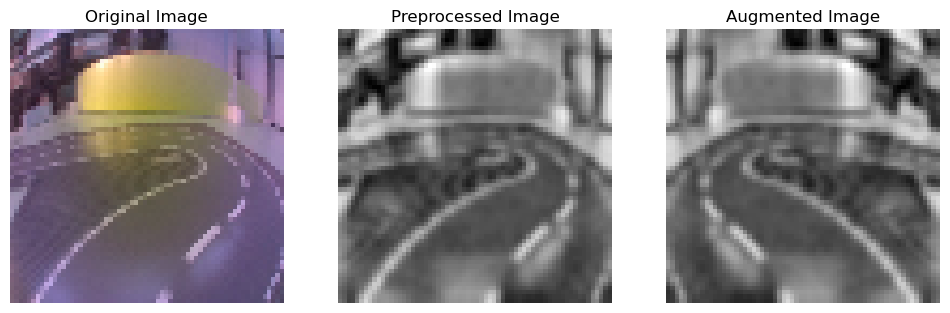

New type:  <class 'numpy.ndarray'>
labels:  [ 1.         -0.12571023]


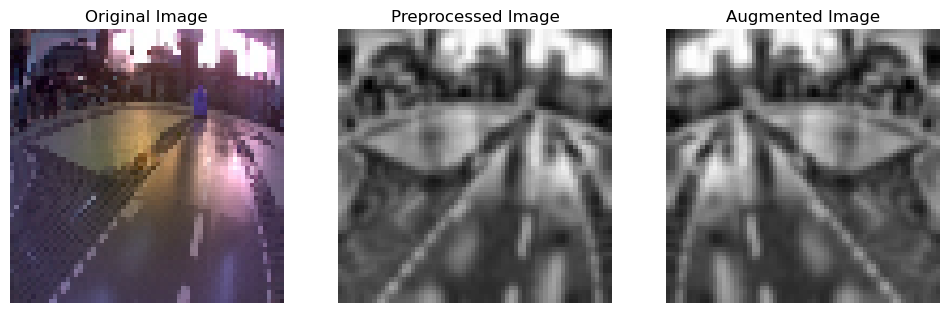

New type:  <class 'numpy.ndarray'>
labels:  [ 1.         -0.63636364]


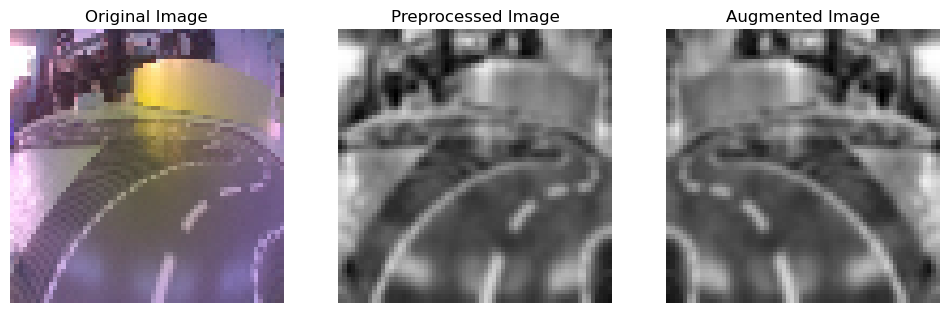

New type:  <class 'numpy.ndarray'>
labels:  [1.         0.90198864]


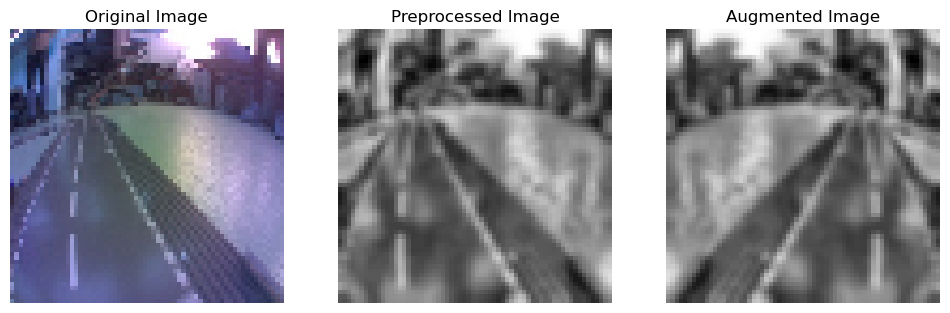

In [ ]:
images, labels = next(loader)

for i in range(0, 8, 2):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    
    image_content = images[i]
    
    # image_content = cv2.cvtColor(image_content, cv2.COLOR_BGR2GRAY)
    # img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16)).apply(image_content)
    # img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    
    # #img_crop = img_blurred[image_size//2:image_size, 0:image_size]
    # img_crop = cv2.resize(img_blurred, (image_size, image_size))

    img_preprocessed = preprocess(image_content)

    img_augmented = cv2.flip(img_preprocessed, 1)
    
    print("New type: ", type(image_content))
    print("labels: ", labels[i])
    ax[0].imshow(images[i])
    ax[0].set_title("Original Image")
    ax[1].imshow(img_preprocessed, cmap="gray")
    ax[1].set_title("Preprocessed Image")
    ax[0].axis("off")
    ax[1].axis("off")
    
    ax[2].imshow(img_augmented, cmap="gray")
    ax[2].set_title("Augmented Image")
    ax[2].axis("off")
    plt.show()

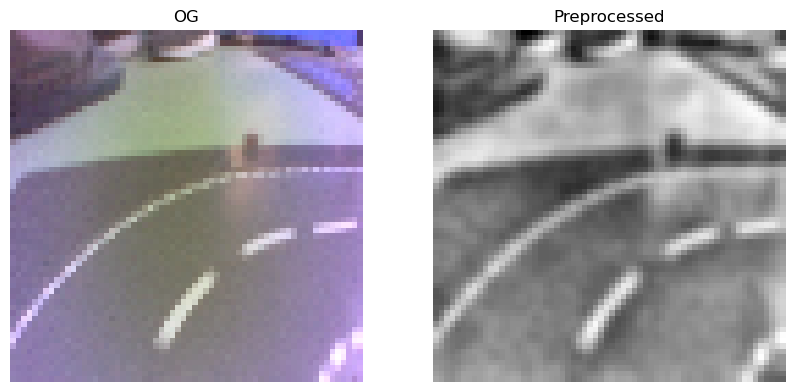

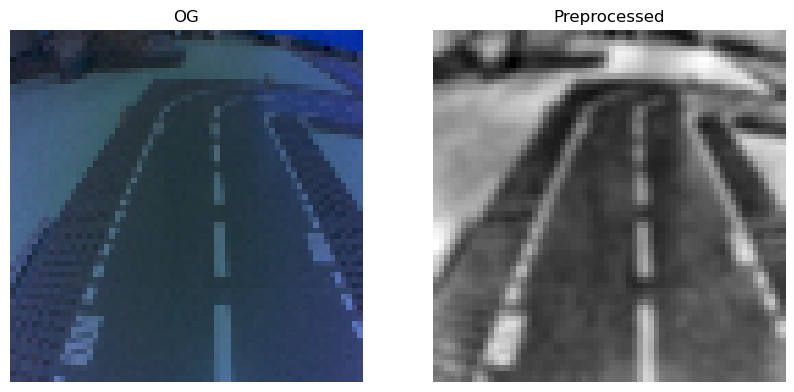

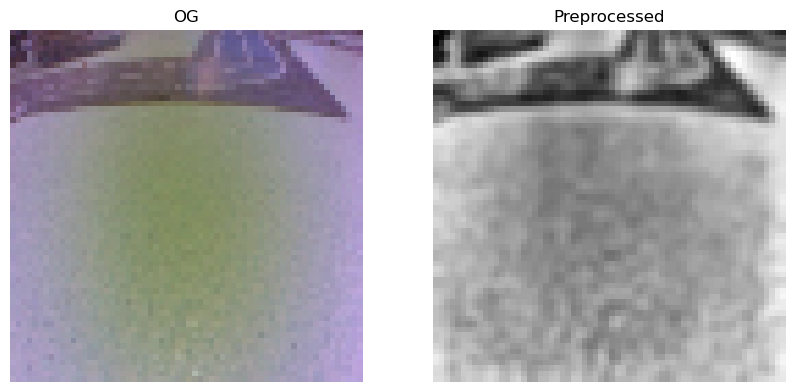

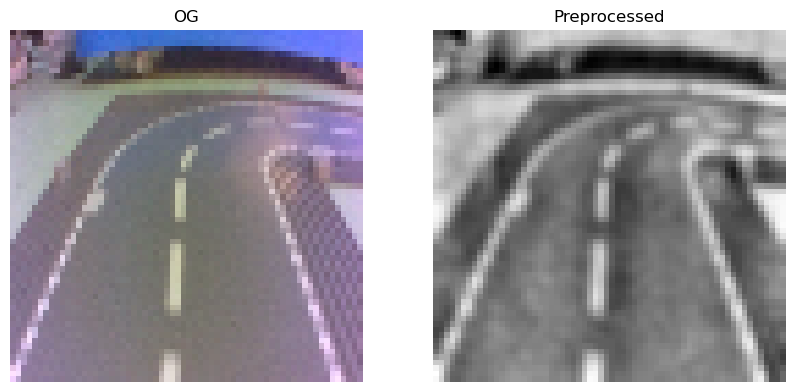

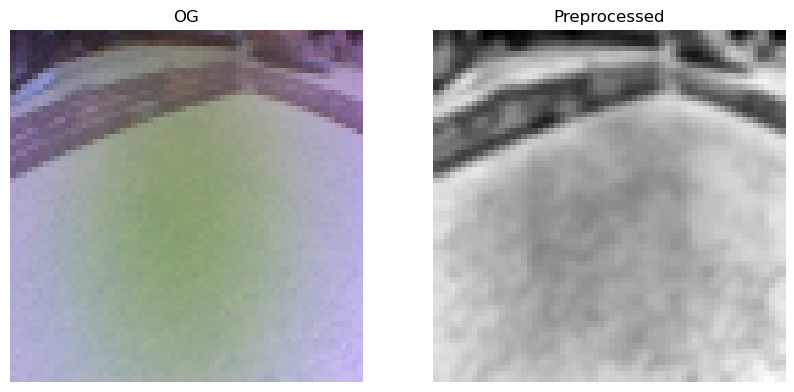

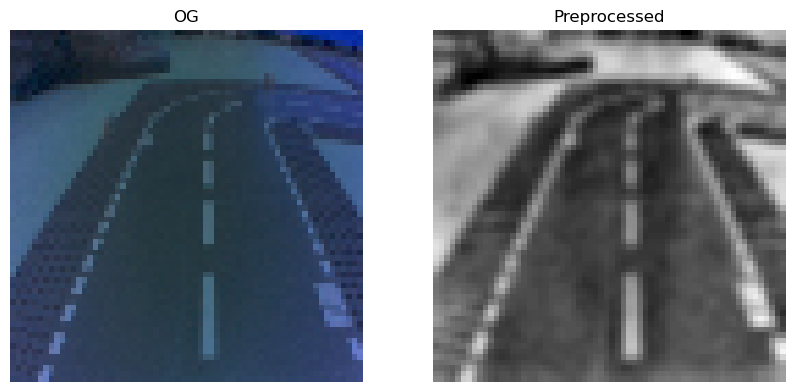

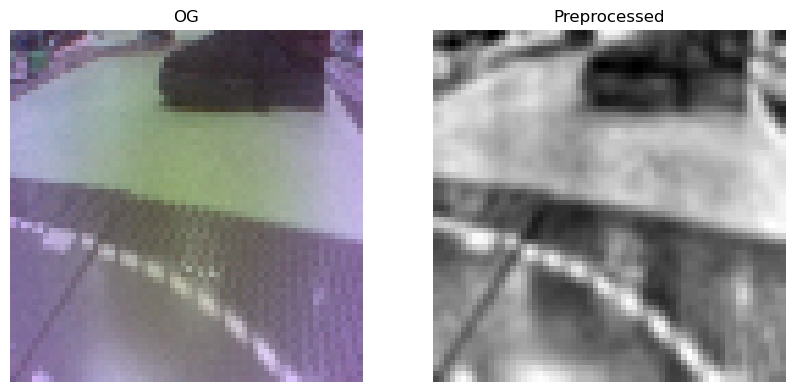

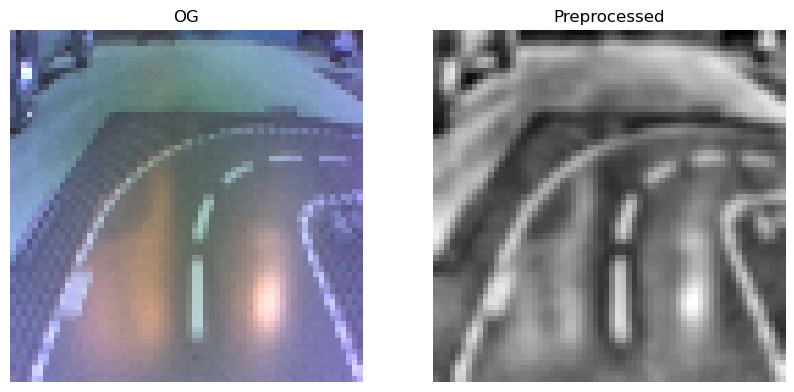

In [ ]:
photo_path = "../test_runs/new_img"

image_paths = glob(os.path.join(photo_path, "*.jpg"))

random.shuffle(image_paths)

for img_path in image_paths[:8]:
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (image_size, image_size))
    if img_bgr is None:
        print(f"Image not found: {img_path}")
        continue
    
    preprocessed_img = preprocess(img_bgr)
    
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_bgr)
    ax[0].set_title(f"OG")
    ax[0].axis("off")
    ax[1].imshow(preprocessed_img, cmap='gray')
    ax[1].set_title(f"Preprocessed")
    ax[1].axis("off")
    plt.show()